## Création d'un service REST avec 

Nous utiliserons un exemple d'application dans ce guide : un site de micro-blogging appelé MyThoughts, un service simple qui nous permettra de publier et de lire de courts messages ou réflexions. Le site Web nous permet de nous connecter, de publier une nouvelle pensée, de voir nos pensées et de rechercher des pensées dans le système

Dans un premier temps, nous allons dessiner un schéma architectural du monolithe. Réduisez le système actuel à une liste de blocs qui interagissent les uns avec les autres. 

Nous parlerons de la manière de développer ce microservice en tant qu'application utilisant Python. Ce microservice sera prêt à interagir avec d'autres microservices via une interface webRESTful standard, ce qui en fait la base de notre système global d'architecture de microservices. implémenter le microservice. Enfin, nous verrons comment tester l'application pour être sûr qu'elle fonctionne correctement. Les sujets suivants seront traités dans ce guide : 

* Analyse du microservice du backend de pensées
* Concevoir l'API RESTful 
* Définir le schéma de la base de données
* Mettre en œuvre le service
* Test du code

À la fin du guide, vous saurez comment développer avec succès une application de microservice, y compris les différentes étapes de la conception aux tests




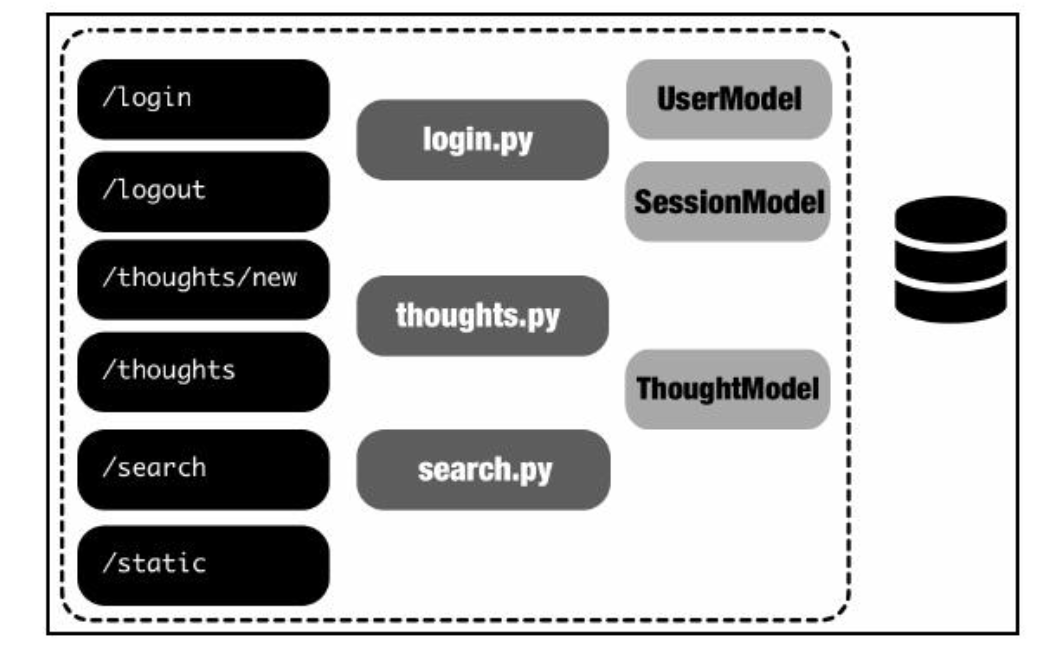

## Analyser les pensées Backendmicroservice

Rappelons-nous le diagramme des microservices:

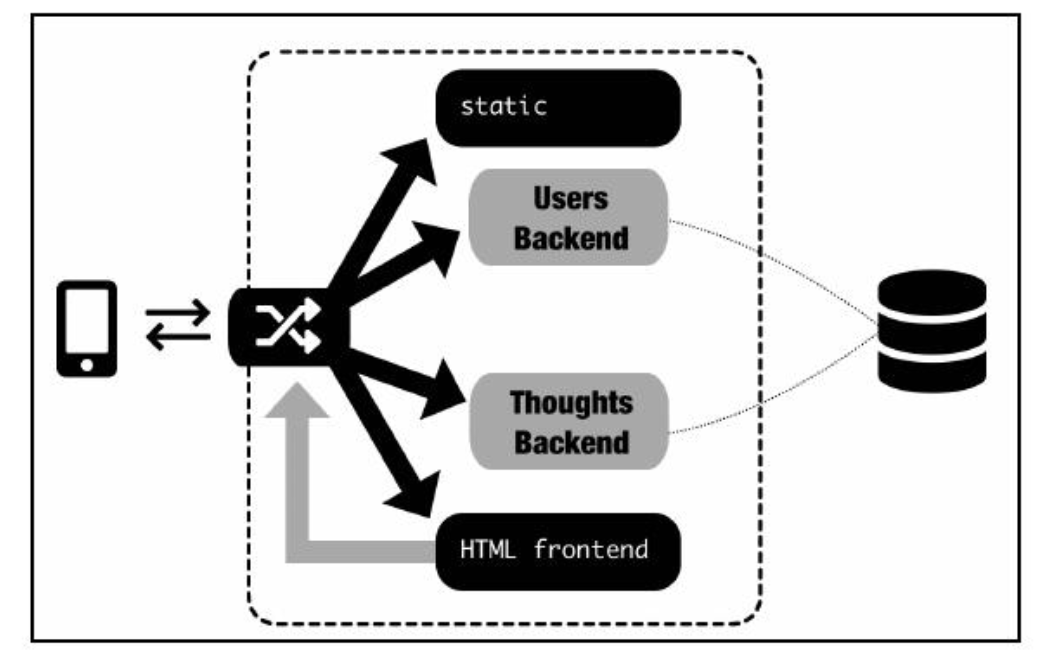

Le diagramme montre les différents éléments de notre exemple de système : les deux backends, les utilisateurs et les pensées et le frontend HTML. Le backend de pensées sera chargé de stocker les nouvelles pensées, de récupérer celles qui existent et de rechercher dans la base de données

## Comprendre la couche de sécurité

Comme le Thinks Backend sera disponible en externe, nous devons implémenter une couche de sécurité. Cela signifie que nous devons identifier l'utilisateur qui produit les actions et vérifier leur validité. Pour cet exemple de service, nous allons créer une nouvelle pensée à partir de l'utilisateur connecté, et nous récupérerons ses pensées, pensées créées par l'utilisateur actuellement connecté.

Cette couche de sécurité se présentera sous la forme d'un en-tête. Cet en-tête contiendra des informations signées par le backend de l'utilisateur, vérifiant son origine. Il prendra la forme d'un JSON WebToken (JWT), https://jwt.io/introduction/  , qui est une norme à cet effet. Le JWT lui-même est crypté, mais les informations contenues ici sont pour la plupart uniquement pertinent pour vérifier l'utilisateur qui a été connecté


    Un JWT n'est pas la seule possibilité pour le token, et il existe d'autres
    alternatives telles que le stockage des données équivalentes dans un cookie
    de session ou dans des environnements plus sécurisés en utilisant des
    modules similaires tels que PASETO(https://github.com/paragonie/paseto).
    Assurez-vous d'examiner les implications de sécurité de votre système, qui
    dépassent le cadre de ce guide.

Cette méthode doit être gérée par l'équipe Users Backend et être conditionnée de manière à ce que les autres microservices puissent l'utiliser. Pour ce guide, nous allons inclure le code dans ce microservice, mais nous verrons plus tard comment le créer afin qu'il soit lié au Backend des utilisateurs. Si les requêtes n'ont pas d'en-tête valide, l'API retournera un status code 401 Unauthorized

    Notez que tous les points de terminaison d'API ne nécessitent pas
    d'authentification. En particulier, la recherche n'a pas besoin d'être enregistrée. 
    
Avec une compréhension du fonctionnement du système d'authentification, nous pouvons commencer à concevoir l'interface API

## Conception de l'API RESTful

Nous suivrons les principes de la conception RESTful pour notre API. Cela signifie que nous utiliserons des URI construits qui représentent des ressources, puis utiliserons les méthodes HTTP pour effectuer des actions sur ces ressource.

    Dans cet exemple, nous n'utiliserons que les méthodes GET (pour récupérer),
    POST (pour créer) et DELETE (pour supprimer) car les pensées ne sont pas
    modifiables. N'oubliez pas que PUT (pour écraser complètement) et PATCH
    (pour effectuer une mise à jour partielle ) sont également disponibles

L'une des principales propriétés des API RESTful est que les requêtes doivent être sans état, ce qui signifie que chaque requête est totalement autonome et peut être servie par n'importe quel serveur. 

Toutes les données requises doivent être soit chez le client (qui les enverra jointes à la requête) soit dans une base de données (ainsi le serveur les récupérera intégralement). Cette propriété est une exigence stricte lors de la gestion des conteneurs Docker, car ils peuvent être détruits et recréés sans avertissement. Bien qu'il soit courant d'avoir des ressources qui correspondent directement aux lignes d'une base de données, cela n'est pas nécessaire. 

Les ressources peuvent être une composition de différents tableaux, une partie d'entre eux, ou même représenter quelque chose de différent ensemble, comme une agrégation de données, que certaines conditions soient remplies, ou une prévision basée sur l'analyse des données actuelles.

Analysez les besoins du service et ne Ne vous sentez pas limité par la conception de votre base de données existante. La migration d'un microservice est une bonne occasion de revoir les anciennes décisions de conception et d'essayer d'améliorer le système général. 

N'oubliez pas non plus les principes de l'application Twelve-Factor (https://12factor.net/ ) pour améliorer la conception. Il est toujours bon d'avoir un bref rappel sur REST avant de commencer une conception d'API, vous pouvez donc vérifier https://restfulapi.net/  pour un récapitulatif

Spécification des points de terminaison de l'APIN otre interface API sera la suivante.

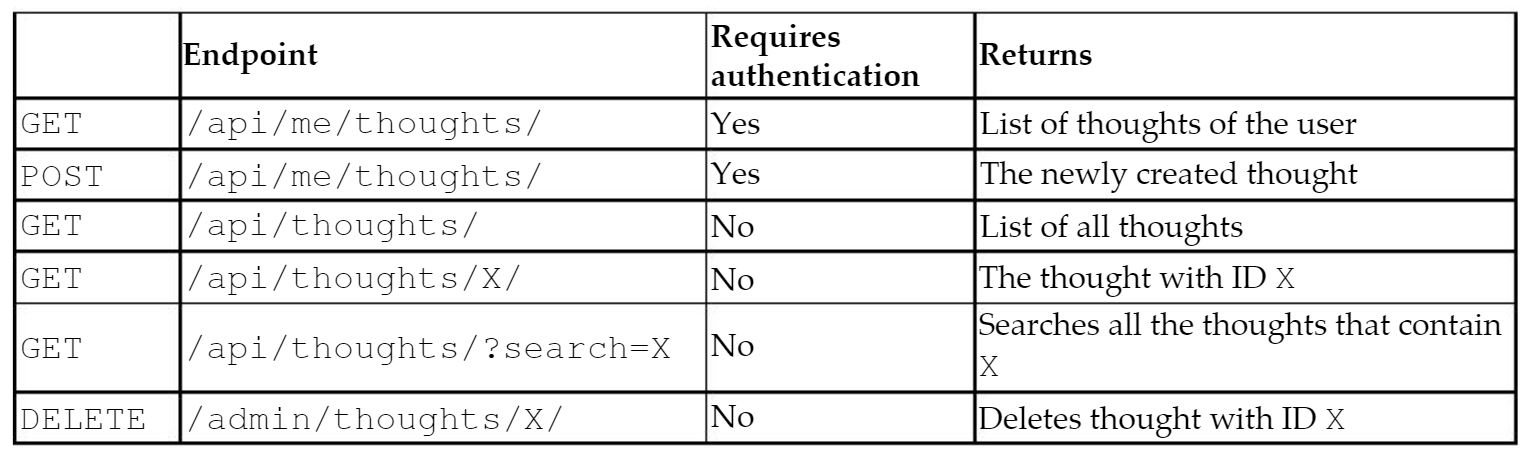

Notez qu'il y a deux éléments de l'API : 

* une API publique, commençant par /api : 
  * Une API publique authentifiée, commençant par /api/me. L'utilisateur doit être authentifié pour effectuer ces actions. Une demande non authentifiée renverra un code d'état 401 non autorisé. 
  * Une API publique non authentifiée, commençant par /api. Tout utilisateur, même non authentifié, peut effectuer ces actions. 
  
* Une API d'administration (commençant par /admin). Cela ne sera pas exposé publiquement. Il épargne l'authentification et permet d'effectuer des opérations qui ne sont pas conçues pour être effectuées par les clients
L'étiquetage clair avec un préfixe aide à auditer les opérations et signifie clairement qu'elles ne doivent pas être disponibles en dehors de votre centre de données. 

Le format d'une pensée est le suivant :


    thought
    {    
      id integer    
      username string    
      text string    
      timestamp string($date-time)
      }


Pour en créer un, seul le texte doit être envoyé. L'horodatage est défini automatiquement, l'ID est créé automatiquement et le nom d'utilisateur est détecté par les données d'authentification. 

Comme il s'agit d'un exemple, cette API est conçue pour être minimale. En particulier, davantage de points de terminaison d'administrateur pourraient être créés pour usurper efficacement l'identité d'un utilisateur et permettre des actions d'administrateur. 

L'action DELETE a été la première action incluse comme moyen de nettoyage des tests. Un dernier détail : il y a un débat sur la question de savoir s'il est préférable de terminer les ressources URI avec une barre oblique finale ou non.

 Lorsque vous travaillez avec Flask, cependant, les définir avec une barre oblique renverra un code d'état de redirection, 308 PERMANENT_REDIRECT, pour une demande sans la fin appropriée. Dans tous les cas, essayez d'être cohérent pour éviter toute confusion.

 Définir le schéma de la base de données Le schéma de la base de données est simple et hérité du monolithe. Nous ne nous soucions que des pensées, stockées dans la table think_model, donc la structure de la base de données est la suivante :

 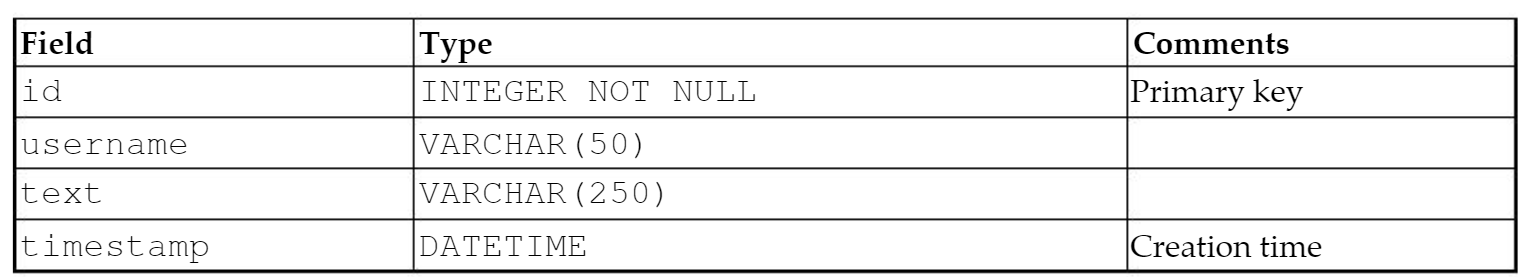

Cette table est représentée en code dans le fichier ideas_backend/models.py, décrit au format SQLAlchemy avec le code suivant :


    class ThoughtModel(db.Model):
      id = db.Column(db.Integer, primary_key=True)
      username = db.Column(db.String(50))
      text = db.Column(db.String(250))
      timestamp = db.Column(db.DateTime, server_default=func.now())


SQLAlchemy est capable de créer la table à des fins de test ou pour le mode de développement. Pour ce guide, nous avons défini la base de données comme étant SQLite, qui stocke les données dans le fichier db.sqlite3

## Travailler avec SQLAlchemy

SQLAlchemy (https://www.sqlalchemy.org/) est un module Python puissant pour travailler avec les bases de données SQL. Il existe deux approches pour gérer les bases de données avec un langage de haut niveau tel que Python. L'une consiste à conserver l'approche de bas niveau et à effectuer des instructions SQL brutes, en récupérant les données telles qu'elles se trouvent dans la base de données. L'autre consiste à faire abstraction de la base de données à l'aide d'un mappeur objet-relationnel (ORM) et à utiliser l'interface sans entrer dans les détails de sa mise en œuvre.


Après avoir défini un modèle, nous pouvons effectuer une requête en utilisant l'attribut de requête dans le filtre de modèle en conséquence :

    # Retrieve a single thought by its primary key
    thought = ThoughtModel.query.get(thought_id)
    
    # Retrieve all thoughts filtered by a username
    thoughts = ThoughtModel.query.filter_by(username=username).order_by('id').all()


Le stockage et la suppression d'une ligne nécessitent l'utilisation de la session, puis sa validation :



    # Create a new thought
    
    new_thought = ThoughtModel(username=username, text=text,timestamp=datetime.utcnow())
    
    db.session.add(new_thought)
    db.session.commit()
    
    # Retrieve and delete a thought
    
    thought = ThoughtModel.query.get(thought_id)
    
    db.session.delete(thought)
    db.session.commit()


Pour voir comment configurer l'accès à la base de données, consultez le fichier ideas_backend/db.py


## Implémentation du service

Pour implémenter ce microservice, nous utiliserons Flask-REST

Plus (https://flask-restplus.readthedocs.io/en/stable/). Il s'agit d'une extension Flask (https://palletsprojects.com/p/flask/). Flask est un microframework Python bien connu pour les applications Web qui est particulièrement efficace pour implémenter des microservices, car il est petit, facile à utiliser et compatible avec la pile technologique habituelle en termes d'applications Web, car il utilise le protocole Web ServerGateway Interface (WSGI).

## Présentation de Flask-RESTPlus

Flask est capable d'implémenter une interface RESTful, mais Flask-RESTPlus ajoute des fonctionnalités très intéressantes qui permettent de bonnes pratiques de développement et une vitesse de développement :

* Il définit des espaces de noms, qui sont des moyens de créer des préfixes et de structurer le code. Cela facilite la maintenance à long terme et facilite la conception lors de la création de nouveaux points de terminaison. 

    Si vous avez plus de 10 points de terminaison dans un même espace de noms,
    il est peut-être temps d'envisager de le diviser. Utilisez un espace de
    noms par fichier et laissez la taille du fichier indiquer quand c'est une
    bonne idée d'essayer de faire une division

* Il a une solution complète pour l'analyse des paramètres d'entrée. Cela signifie que nous avons un moyen simple de traiter les points de terminaison qui nécessitent plusieurs paramètres et les valide. L'utilisation du module Request Parsing (https://flask-restplus.readthedocs.io/en/stable/parsing.  html) est similaire à l'utilisation du module de ligne de commande argparse (https://docs.python.org/3/library/argparse.html) qui est inclus dans la bibliothèque standard Python. Il permet de définir des arguments dans le corps de la requête, des en-têtes, des chaînes de requête ou m²²ême des cookies.

* De la même manière, il dispose d'un framework de sérialisation pour les objets résultants. Flask-RESTful l'appelle le marshalling de réponse (https://flask-restplus.readthedocs.io/en/stable/marshalling.html). Cela permet de définir des objets réutilisables, clarifiant l'interface et simplifiant le développement. S'il est activé, il autorise également les masques de champ, qui renvoient des objets partiels.

* Il prend en charge la documentation complète de l'API Swagger. Swagger (https://swagger.io/) est un projet open source pour aider à la conception, la mise en œuvre, la documentation et le test des services Web API RESTful, conformément aux spécifications OpenAPI standard. Flask-RESTPlus génère automatiquement une spécification Swagger et une page d'auto-documentation :

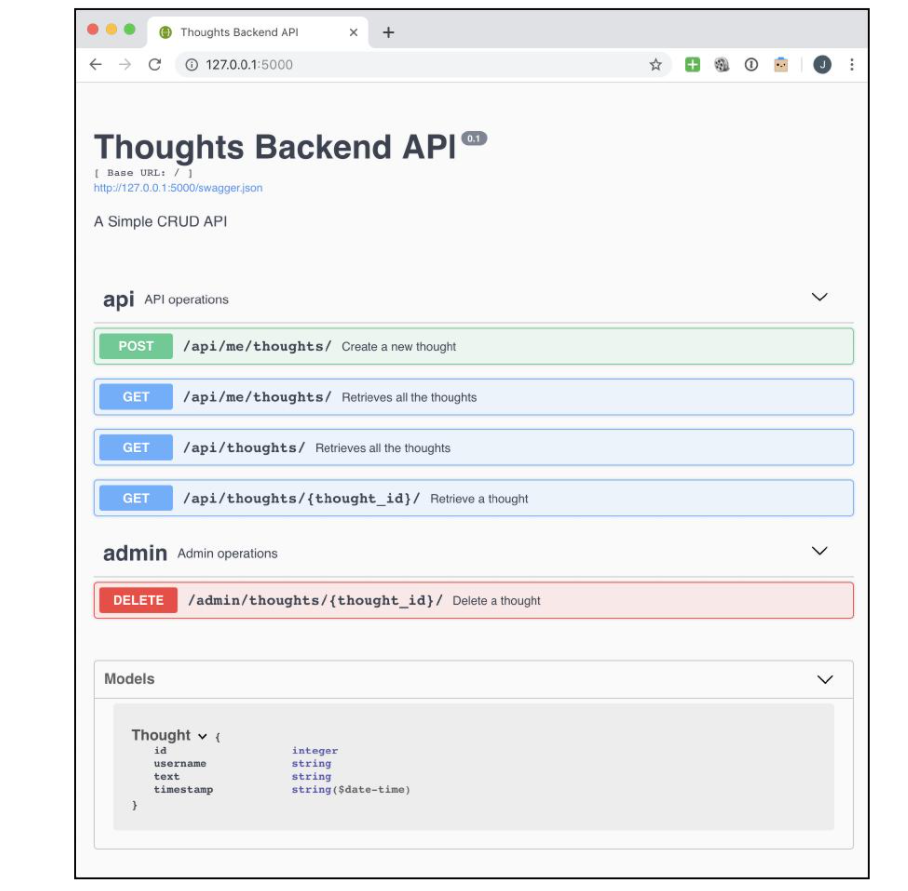

D'autres éléments intéressants de Flask sont dérivés du fait qu'il s'agit d'un projet populaire et qu'il contient de nombreux outils pris en charge

* Nous utiliserons le connecteur pour SQLAlchemy, Flask-SQLAlchemy (https://flask-sqlalchemy.palletsprojects.com/en/2.x/ ). Sa documentation couvre la plupart des cas courants, tandis que la documentation SQLAlchemy est plus détaillée et peut être un peu écrasante.
* Pour exécuter les tests, le module pytest-flask (https://pytest-flask.readthedocs.io/en/latest/) crée des fixture prêts à fonctionner avec une application Flask. Nous en parlerons plus en détail dans la section Tester le code.

## Gestion des ressources

Une application RESTful typique a la structure générale suivante :

* 1. Une ressource définie par URL. Cette ressource permet une ou plusieurs actions via des méthodes HTTP (GET, POST, etc.)

* 2. Lorsque chacune des actions est appelée, le framework achemine la requête jusqu'à ce que le code défini exécute l'action

* 3. S'il y a des paramètres d'entrée, ils devront d'abord être validés
* 4. Effectuez l'action et obtenez une valeur de résultat. Cette action impliquera normalement un ou plusieurs appels à la base de données, qui se feront sous forme de modèles

* 5. Préparez la valeur de résultat résultante et encodez-la d'une manière qui est comprise par le client, généralement en JSON.
* 6. Renvoyez la valeur encodée au client avec le code d'état adéquat


La plupart de ces actions sont effectuées par le cadre. Certains travaux de configuration doivent être effectués, mais c'est là que notre framework Web, Flask-RESTPlus dans cet exemple, vous aidera le plus. En particulier, tout sauf l'étape 4 sera grandement simplifié. Regardons un exemple de code simple (disponible dans GitHub) pour le décrire :

    api_namespace = Namespace('api', description='API operations')
    
    @api_namespace.route('/thoughts/<int:thought_id>/')
    class ThoughtsRetrieve(Resource):    
      
      @api_namespace.doc('retrieve_thought')    
      @api_namespace.marshal_with(thought_model)    
      
      def get(self, thought_id):        
      '''        Retrieve a thought

      '''        
      
      thought = ThoughtModel.query.get(thought_id)        
      
      if not thought:            
        # The thought is not present            
        return '', http.client.NOT_FOUND        
      
      return thought


Cela implémente l'action GET /api/thoughts/X/, en récupérant une seule pensée par ID


Analysons chacun des éléments. Notez que les lignes sont regroupées par thème :

* 1. Tout d'abord, nous définissons la ressource par son URL. Notez que api_namespace définit le préfixe api sur l'URL, ce qui valide que le paramètre X est un entier :

    
    api_namespace = Namespace('api', description='API operations')
    @api_namespace.route('/thoughts/<int:thought_id>/')
    class ThoughtsRetrieve(Resource):

* 2. La classe vous permet d'effectuer plusieurs actions sur la même ressource. Dans ce cas , nous n'en faisons qu'une : l'action GET

* 3. A noter que le paramètre thought_id, encodé dans l'URL, est passé en paramètre à la méthode

    
    class ThoughtsRetrieve(Resource):    
      def get(self, thought_id):

* 4. Nous pouvons maintenant exécuter l'action, qui est une recherche dans la base de données pour récupérer un objet unique. Appelez ThoughModel pour rechercher la pensée spécifiée. S'il est trouvé, il est renvoyé avec un code d'état http.client.OK (200). S'il n'est pas trouvé, un résultat vide et un code d'état http.client.NOT_FOUND 404 sont renvoyés :


    def get(self, thought_id):    
      thought = ThoughtModel.query.get(thought_id)    
      if not thought:        
        # The thought is not present        
        return '', http.client.NOT_FOUND    
      return thought
* 5. L'objet de pensée est renvoyé. Le décorateur marshal_with décrit comment l'objet Python doit être sérialisé dans une structure JSON. Nous verrons plus tard comment le configurer :


    @api_namespace.marshal_with(thought_model)
    def get(self, thought_id):    
      ...    
      return thought

* 6. Enfin, nous avons de la documentation, y compris la docstring qui sera rendue par l'API Swagger générée automatiquement



    class ThoughtsRetrieve(Resource):    
    
    @api_namespace.doc('retrieve_thought')    
    def get(self, thought_id):       
      '''        Retrieve a thought        
      '''        
      ...


Comme vous pouvez le voir, la plupart des actions sont configurées et effectuées via Flask-RESTPlus, et le gros du travail en tant que développeur est la grosse étape 4. Il y a cependant du travail à faire, configurer les paramètres d'entrée attendus et les valider. , ainsi que comment sérialiser l'objet renvoyé dans le JSON approprié. Nous verrons comment Flask-RESTPlus peut nous y aider.

## Analyse des paramètres d'entrée

Les paramètres d'entrée peuvent prendre différentes formes. Lorsque nous parlons de paramètres d'entrée, nous parlons principalement de deux types :

*  Paramètres de requête de chaîne encodés dans l'URL. Ceux-ci sont normalement utilisés pour les requêtes GET et ressemblent à ce qui suit : http://test.com/some/path?param1=X&param2=Y


Ils font partie de l'URL et seront stockés dans n'importe quel journal en cours de route. Les paramètres sont encodés dans leur propre format, appelé encodage URL (https://www.urlencoder.io/learn/). Vous avez probablement remarqué que, par exemple, un espace vide est transformé en %20


    Normalement, nous n'aurons pas à décoder les paramètres de requête manuellement, 
    car des frameworks tels que Flask le font pour nous, mais la bibliothèque
    standard Python a des utilitaires pour le faire (https://docs.python.org/3/ bibliothèque/urllib.parse.html)


* Regardons le corps de la requête HTTP. Ceci est généralement utilisé dans les requêtes POST et PUT. Le format spécifique peut être spécifié à l'aide du Content-Typeheader. Par défaut, l'en-tête Content-Type est défini comme application/x-www-form-urlencoded, qui l'encode dans l'encodage URL. Dans les applications modernes, ceci est remplacé par application/json pour les encoder en JSON


    Le corps des requêtes n'est pas stocké dans un journal. On s'attend à ce
    qu'une requête GET produise le même résultat lorsqu'elle est appelée
    plusieurs fois, ce qui signifie qu'elles sont idempotentes. Par conséquent,
    il peut être mis en cache par certains proxy ou d'autres éléments. C'est la
    raison pour laquelle votre navigateur demande une confirmation avant
    d'envoyer à nouveau une requête POST, car cette opération peut générer des
     résultats différents


Mais il y a deux autres endroits pour passer des paramètres qui peuvent également être utilisés : 

* En tant que partie de l'URL : des éléments tels que l'identifiant pensé sont des paramètres. Essayez de suivre les principes RESTful et définissez vos URL en tant que ressources pour éviter toute confusion. Il est préférable de laisser les paramètres de requête comme facultatifs. 

* Headers : normalement, les en-têtes donnent des informations sur les métadonnées, telles que le format de la requête, le format attendu ou les données d'authentification. Mais ils doivent également être traités comme des paramètres d'entrée.


Tous ces éléments sont décodés automatiquement par Flask-RESTPlus, nous n'avons donc pas besoin de nous occuper des encodages et des accès de bas niveau. Voyons comment cela fonctionne dans notre exemple. Ce code est extrait de celui de GitHub, et abrégé pour décrire les paramètres d'analyse :



    authentication_parser = api_namespace.parser()
    authentication_parser.add_argument('Authorization', location='headers', type=str, help='Bearer AccessToken')
    
    thought_parser = authentication_parser.copy()
    thought_parser.add_argument('text', type=str, required=True, help='Text ofthe thought')
    
    @api_namespace.route('/me/thoughts/')
    class MeThoughtListCreate(Resource):
      
      @api_namespace.expect(thought_parser)    
      def post(self):        
      
        args = thought_parser.parse_args()        
        username = authentication_header_parser(args['Authorization'])
        text=args['text']        
        ...



On définit un parser dans les lignes suivantes :


    authentication_parser = api_namespace.parser()
    authentication_parser.add_argument('Authorization',location='headers', type=str, help='Bearer Access Token')
    
    thought_parser = authentication_parser.copy()
    
    thought_parser.add_argument('text', type=str, required=True, help='Text ofthe thought')


authentication_parser est hérité par Thought_parser pour étendre les fonctionnalités et combiner les deux. Chacun des paramètres est défini en termes de type et s'ils sont obligatoires ou non. Si un paramètre requis est manquant ou si un autre élément est incorrect, Flask-RESTPlus génère une erreur 400 BAD_REQUEST, donnant un retour sur ce qui s'est mal passé.


Parce que nous voulons gérer l'authentification d'une manière légèrement différente, nous l'étiquetons comme non requis et lui permettons d'utiliser la valeur par défaut (telle que créée pour le framework) de None. Notez que nous spécifions que le paramètre Authorization doit être dans les en-têtes.


La méthode post obtient un décorateur pour montrer qu'elle attend le paramètre Thought_parser, et nous l'analysons avec parse_args :



    @api_namespace.route('/me/thoughts/')
    class MeThoughtListCreate(Resource):    
    
      @api_namespace.expect(thought_parser)    
      def post(self):        
        args = thought_parser.parse_args()        
        ...


De plus, args est maintenant un dictionnaire avec tous les paramètres correctement analysés et utilisés dans les lignes suivantes.


Dans le cas particulier de l'en-tête d'authentification, il existe une fonction spécifique avec laquelle fonctionner, et elle renvoie un code d'état 401 UNAUTHORIZED via l'utilisation de abort. Cet appel arrête immédiatement une requête :



    def authentication_header_parser(value):    
      username = validate_token_header(value, config.PUBLIC_KEY)    
      if username is None:        
        abort(401)    
      return username

Nous laisserons de côté un instant l'action à effectuer (stocker une nouvelle pensée dans la base de données), et nous concentrerons sur l'autre configuration du framework, pour sérialiser le résultat dans un objet JSON.





## Sérialisation des résultats

Nous devons renvoyer nos résultats. Le moyen le plus simple de le faire est de définir la forme que le JSONresult devrait avoir via un modèle de sérialisation ou de marshalling (https://flask-restplus.readthedocs.io/en/stable/marshalling.html) .Un modèle de sérialiseur est défini comme un dictionnaire avec les champs attendus et un type de champ :



    from flask_restplus import fields
    
    model = {    
      'id': fields.Integer(),    
      'username': fields.String(),    
      'text': fields.String(),    
      'timestamp': fields.DateTime(),
      }
      
      thought_model = api_namespace.model('Thought', model)


Le modèle prendra un objet Python et convertira chacun des attributs en l'élément JSON correspondant, tel que défini dans le champ :



    @api_namespace.route('/me/thoughts/')
    class MeThoughtListCreate(Resource):    
    
    @api_namespace.marshal_with(thought_model)    
    def post(self):        
      ...        
      
      new_thought = ThoughtModel(...)        
      return new_thought


Notez que new_thought est un objet ThoughtModel, tel que récupéré par SQLAlchemy. Nous le verrons en détail par la suite, mais pour l'instant, il suffit de dire qu'il possède tous les attributs définis dans le modèle : id, username, text et timestamp. 

Tout attribut non présent dans l'objet memory aura la valeur None par défaut. Vous pouvez remplacer cette valeur par défaut par une valeur qui sera renvoyée. Vous pouvez spécifier une fonction, elle sera donc appelée pour récupérer une valeur lorsque la réponse est générée. C'est une façon d'ajouter des informations dynamiques à votre objet :


    model = {    'timestamp': fields.DateTime(default=datetime.utcnow),}

  
Vous pouvez également ajouter le nom de l'attribut à sérialiser, au cas où il serait différent du résultat attendu, ou ajouter une fonction lambda qui sera appelée pour récupérer la valeu


    model = {    
        'thought_text': fields.String(attribute='text'),
        'thought_username': fields.String(attribute=lambda x: x.username), 
        }


Pour des objets plus complexes, vous pouvez imbriquer des valeurs comme celle-ci. Notez que cela définit deux modèles du point de vue de la documentation et que chaque élément Nested crée une nouvelle portée. Vous pouvez également utiliser List pour ajouter plusieurs instances du même genre :




    extra = {   
      'info': fields.String(),
    }
    
    extra_info = api_namespace.model('ExtraInfo', extra)
    
    model = {    
      'extra': fields.Nested(extra),    
      'extra_list': fields.List(fields.Nested(extra)), 
      }


Certains des champs disponibles ont plus d'options, telles que le format de date pour les champs DateTime. Consultez la documentation complète du champ (https://flask-restplus.readthedocs.io/en/stable/api.html#models) pour plus de détails. Si vous retournez une liste d'éléments, ajoutez le paramètre as_list=True dans le marshal_withdecorator :



    @api_namespace.route('/me/thoughts/')
    class MeThoughtListCreate(Resource):    
    
      @api_namespace.marshal_with(thought_model, as_list=True)   
      def get(self):        
        ...        
        thoughts = (            
          ThoughtModel.query.filter(                
            ThoughtModel.username == username            
            )            
            .order_by('id').all()        
          )        
        return thoughts

  
Le décorateur marshal_with transformera l'objet de résultat d'un objet Python en l'objet de données JSON correspondant. Par défaut, il renverra un code d'état http.client.OK (200), mais nous pouvons retourner un code d'état différent renvoyant deux valeurs : la première est l'objet à marshaler et la seconde est le code d'état. Le paramètre de code dans le décorateur marshal_with est utilisé à des fins de documentation. Notez que dans ce cas, nous devons ajouter l'appel marshal spécifique :


    @api_namespace.route('/me/thoughts/')
    class MeThoughtListCreate(Resource):    
    
      @api_namespace.marshal_with(thought_model,         
      code=http.client.CREATED)    
      def post(self):        
        ...        
        result = api_namespace.marshal(new_thought, thought_model)        
        
        return result, http.client.CREATED

La documentation Swagger affichera tous vos objets marshal définis utilisés :

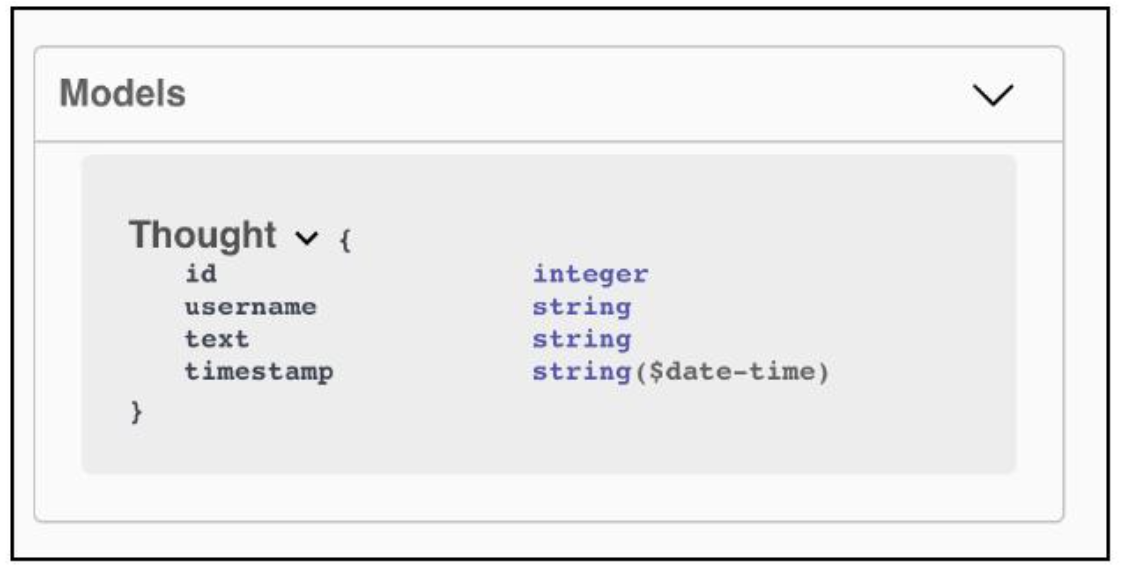

    Un inconvénient de Flask-RESTPlus est que pour entrer et sortir les mêmes
    objets, ils doivent être définis deux fois, car les modules d'entrée et de
    sortie sont différents. Ce n'est pas le cas dans certains autres frameworks
    RESTful, par exemple, dans le framework Django REST (https://www.django-rest-framework.org/). Les mainteneurs de Flask-RESTPlus en sont
     conscients et, selon eux, ils intégreront un module externe, probablement
    marshmallow (https://marshmallow.readthedocs.io/en/stable/ ). 
    Vous pouvez l'intégrer manuellement si vous le souhaitez, car Flask est
    suffisamment flexible pour le faire, jetez un œil à cet exemple (https://marshmallow.readthedocs.io/en/stable/examples.html#quotes-api-flask-sqlalchemy)

## Exécution de l'action

Enfin, nous arrivons à la partie spécifique où les données d'entrée sont propres et prêtes à l'emploi, et nous savons comment renvoyer le résultat. Cette partie implique probablement l'exécution de certaines requêtes de base de données et la composition des résultats. Regardons ce qui suit à titre d'exemple :



    @api_namespace.route('/thoughts/')
    class ThoughtList(Resource):

        @api_namespace.doc('list_thoughts')
        @api_namespace.marshal_with(thought_model, as_list=True)
        @api_namespace.expect(search_parser)
        def get(self):
            '''
            Retrieves all the thoughts
            '''
            args = search_parser.parse_args()
            search_param = args['search']
            query = ThoughtModel.query
            if search_param:
                query = (query.filter(ThoughtModel.text.contains(search_param)))

            query = query.order_by('id')
            thoughts = query.all()

            return thoughts


Vous pouvez voir ici, après avoir analysé les paramètres, nous utilisons SQLAlchemy pour récupérer une requête qui, si le paramètre de recherche est présent, appliquera un filtre. Nous obtenons tous les résultats avec all(), en retournant tous les objets ThoughtModel. Le retour des objets les marshals (les encode en JSON) automatiquement, comme nous l'avons spécifié dans le décorateur marshal_with.

## Authentification des demandes

La logique d'authentification est encapsulée dans le fichier
thoughts_backend/token_validation.py. Celui-ci contient à la fois la génération et la validation de l'en-tête. Les fonctions suivantes génèrent le jeton Bearer :


    def encode_token(payload, private_key):
        return jwt.encode(payload, private_key, algorithm='RS256')



    def generate_token_header(username, private_key):
        '''
        Generate a token header base on the username. Sign using the private key.
        '''
        payload = {
            'username': username,
            'iat': datetime.utcnow(),
            'exp': datetime.utcnow() + timedelta(days=2),
        }
        token = encode_token(payload, private_key)
        token = token.decode('utf8')
        return f'Bearer {token}'

Cela génère une charge utile JWT. Il inclut le nom d'utilisateur à utiliser comme valeur personnalisée, mais il ajoute également deux champs standard, une date d'expiration exp et l'heure de génération iat du jeton. 

Le jeton est ensuite codé à l'aide de l'algorithme RS256, avec une clé privée, et renvoyé dans le format approprié : Bearer <token>. 

L'action inverse consiste à obtenir le nom d'utilisateur à partir d'un en-tête codé. Le code ici est plus long, car nous devons tenir compte des différentes options dans lesquelles nous pouvons recevoir l'en-tête d'authentification. Cet en-tête provient directement de notre API publique, nous devons donc nous attendre à ce que toute valeur et tout programme y soient prêts sur le plan défensif. 

Le décodage du jeton lui-même est simple, car l'action jwt.decode fera ceci :


    def decode_token(token, public_key):
        return jwt.decode(token, public_key, algoritms='RS256')


Mais avant d'arriver à cette étape, nous devons obtenir le jeton et vérifier que l'en-tête est valide dans plusieurs cas, nous vérifions donc d'abord si l'en-tête est vide et s'il a le bon format, en extrayant le jeton 


    def validate_token_header(header, public_key):
        '''
        Validate that a token header is correct
        If correct, it return the username, if not, it
        returns None
        '''
        if not header:
            logger.info('No header')
            return None

        # Retrieve the Bearer token
        parse_result = parse('Bearer {}', header)
        if not parse_result:
            logger.info(f'Wrong format for header "{header}"')
            return None
        token = parse_result[0]

Ensuite, nous décodons le jeton. Si le jeton ne peut pas être décodé avec la clé publique, il lève DecodeError. Le jeton peut également être expiré



        try:
            decoded_token = decode_token(token.encode('utf8'), public_key)
        except jwt.exceptions.DecodeError:
            logger.warning(f'Error decoding header "{header}". '
                          'This may be key missmatch or wrong key')
            return None
        except jwt.exceptions.ExpiredSignatureError:
            logger.error(f'Authentication header has expired')
            return None

        # Check expiry is in the token
        if 'exp' not in decoded_token:
            logger.warning('Token does not have expiry (exp)')
            return None

Ensuite, vérifiez qu'il dispose des paramètres exp et nom d'utilisateur attendus. Si l'un de ces paramètres est manquant, cela signifie que le format du jeton, après décodage, est incorrect. Cela peut arriver lors de la modification du code dans différentes versions :
        
        
        # Check username is in the token
        if 'username' not in decoded_token:
            logger.warning('Token does not have username')
            return None

        logger.info('Header successfully validated')
        return decoded_token['username']


Si tout se passe bien, renvoyez le nom d'utilisateur à la fin. Chacun des problèmes possibles est consigné avec une gravité différente. La plupart des occurrences courantes sont enregistrées avec une sécurité au niveau des informations, car elles ne sont pas graves. Des éléments tels qu'une erreur de format après le décodage du jeton peuvent indiquer un problème avec notre processus d'encodage. Notez que nous utilisons un schéma de clé privée/publique, au lieu d'un schéma de clé symétrique, pour encoder et décoder les jetons. Cela signifie que les clés de décodage et d'encodage sont différentes.


    Techniquement, il s'agit d'une signature/vérification car elle est utilisée
    pour générer une signature, et non pour coder/décoder, mais c'est la convention de dénomination utilisée dans JWT.


Dans notre structure de microservice, seule l'autorité de signature requiert la clé privée. Cela augmente la sécurité car toute fuite de clé dans d'autres services ne pourra pas récupérer une clé capable de signer des jetons de support. Nous devrons cependant générer des clés privées et publiques appropriées.


Pour générer une clé privée/publique, exécutez la commande suivante 


    openssl genrsa -out key.pem 2048



Ensuite, pour extraire la clé publique, utilisez ce qui suit :


    penssl rsa -in key.pem -outform PEM -pubout -out key.pub


Cela générera deux fichiers : key.pem et key.pub avec une paire de clés privée/publique. Les lire au format texte suffira pour les utiliser comme clés d'encodage/décodage du JWTtoken :



      with open('private.pem') as fp:
      >> ..  private_key = fp.read()
      
      >> generate_token_header('peter', private_key)
      'Bearer <token>


Notez que, pour les tests, nous avons généré un exemple de paire de clés qui est attachée sous forme de chaînes. Ces clés ont été créées spécifiquement pour cet usage et ne sont utilisées nulle part ailleurs. Veuillez ne pas les utiliser n'importe où car ils sont disponibles publiquement dans GitHub






## Tester le code

Pour tester notre application, nous utilisons l'excellent framework pytest, qui est l'étalon-or des testeurs pour les applications Python. En gros, pytest a beaucoup de plugins et d'add-ons pour faire face à beaucoup de situations. Nous utiliserons pytest-flask, qui aide à exécuter des tests pour les applications Flask


Pour exécuter tous les tests, appelez simplement pytest dans la ligne de commande :

    pytest


Nous configurons l'utilisation de base, notamment en activant toujours les drapeaux dans le fichier pytest.ini et les appareils dans conftest.py.


## Définir les fixtures pytest 

Les fixture sont utilisés dans pytest pour préparer le contexte dans lequel un test doit être exécuté, le préparer et le nettoyer à la fin. 

Le montage de l'application est attendu par pytest-flask, comme indiqué dans la documentation. Le plugin génère une fixture client que nous pouvons utiliser pour envoyer des requêtes en mode test. Nous voyons ce luminaire en action dans le thoughts_fixture , qui génère trois pensées via l'API et supprime tout après l'exécution de notre test. La structure, simplifiée, est la suivante :

La structure, simplifiée, est la suivante :

* 1. Générez trois pensées. Stocker son thought_id


    @pytest.fixture
    def thought_fixture(client):
        '''
        Generate three thoughts in the system.
        '''

        thought_ids = []
        for _ in range(3):
            thought = {
                'text': fake.text(240),
            }
            header = token_validation.generate_token_header(fake.name(),
                                                            PRIVATE_KEY)
            headers = {
                'Authorization': header,
            }
            response = client.post('/api/me/thoughts/', data=thought,
                                  headers=headers)
            assert http.client.CREATED == response.status_code
            result = response.json
            thought_ids.append(result['id'])

Ensuite, ajoutez le yield pensée_ids au test :

        yield thought_ids

Récupérez toutes les pensées et supprimez-les une par une

        # Clean up all thoughts
        response = client.get('/api/thoughts/')
        thoughts = response.json
        for thought in thoughts:
            thought_id = thought['id']
            url = f'/admin/thoughts/{thought_id}/'
            response = client.delete(url)
            assert http.client.NO_CONTENT == response.status_code


Notez que nous utilisons le module faker pour générer de faux noms et du texte. Vous pouvez consulter sa documentation complète sur https://faker.readthedocs.io/en/stable/  . C'est un excellent moyen de générer des valeurs aléatoires pour vos tests qui évitent de réutiliser test_user et test_text encore et encore. Cela aide également à façonner vos tests, en vérifiant l'entrée indépendamment et en ne copiant pas aveuglément un espace réservé.


Notez également l'utilisation du fixture client, qui est fourni par pytest-flask